## Face and Facial Keypoint detection

Apply the trained network:

1. Detect all the faces in an image using a face detector 
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that your net expect
3. Use the trained model to detect facial keypoints on the image.


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


#### Select an image 


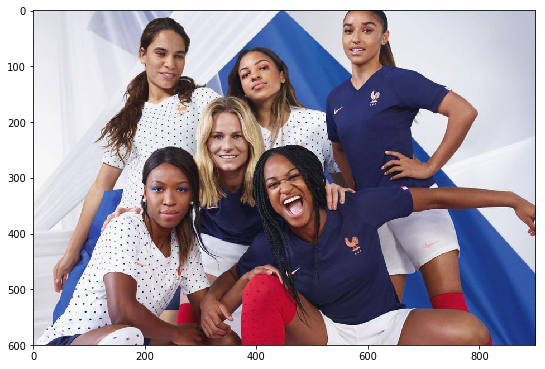

In [18]:
import cv2
# load in color image for face detection
image = cv2.imread('C:/Users/jeanjules.bigeard/OneDrive - Neato Robotics/Documents/team.jpg')

# switch red and blue color channels 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

## Detect all faces in an image

Using OpenCV's pre-trained Haar Cascade classifiers.




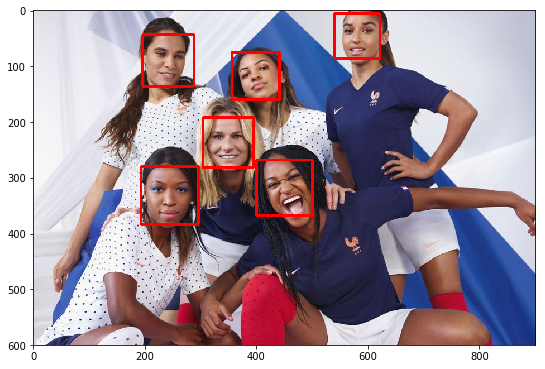

In [19]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
faces = face_cascade.detectMultiScale(image, 1.2, 2)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

## Loading in a trained model


In [20]:
import torch
from models import Net

net = Net()

# Load the model
net.load_state_dict(torch.load('saved_models/keypoints_model.pt'))

# print the model 
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv4_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=36864, out_features=4000, bias=True)
  (fc1_bn): BatchNorm1d(4000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=4000, out_features=1000, bias=True)
  (fc2_bn): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=T

## Keypoint detection


### Transform each detected face into an input Tensor

1. Convert the face from RGB to grayscale
2. Normalize the grayscale image 
3. Rescale the detected face to be the expected square size 
4. Reshape the numpy image into a torch image.


### Detect and display the predicted keypoints

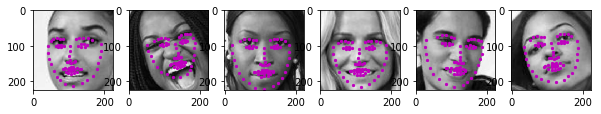

In [23]:
image_copy = np.copy(image)
num_faces = len(faces)
cnt = 0
plt.figure(figsize=(10,10))

# loop over the detected faces 
for (x,y,w,h) in faces:
    cnt = cnt + 1
    
    # Select the region of interest 
    roi = image_copy[y:y+h, x:x+w]
    
    # Convert the face region from RGB to grayscale
    roi_gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)

    roi_gray = np.expand_dims(roi_gray, axis=2)
    
    # Normalize the grayscale image 
    roi_gray = roi_gray / 255.0
    
    ## Rescale the detected face to be the expected square size 
    img_1 = cv2.resize(roi_gray, (224,224))
    img_1 = np.expand_dims(img_1, axis=2)

    # Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    torch_image = img_1.transpose((2, 0, 1))
    
    torch_image = torch.from_numpy(torch_image)
    torch_image = torch_image.unsqueeze_(0)
    torch_image = torch_image.type(torch.FloatTensor)

    # Make facial keypoint predictions using your loaded, trained network 
    output_pts = net(torch_image)
    output_pts = output_pts.view(output_pts.size()[0], 68, -1)
    
    # Display each detected face and the corresponding keypoints  
    ax = plt.subplot(1, num_faces, cnt)
    numpy_image = torch_image.numpy()[0]
    numpy_image = np.transpose(numpy_image, (1, 2, 0)) 
    
    output_pts = output_pts[0].data
    output_pts = output_pts.numpy()
    output_pts = output_pts * 50.0 + 100
    
    plt.imshow(np.squeeze(numpy_image), cmap='gray')
    plt.scatter(output_pts[:, 0], output_pts[:, 1], s=20, marker='.', c='m')
    
plt.show()